# Install packages

In [ ]:
!pip install efficientnet
!pip install pyyaml h5py  

     |████████████████████████████████| 51kB 3.2MB/s 


# Import Packages

In [ ]:
import os
import math
import pandas as pd
from scipy.io import loadmat
from random import randrange
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

import efficientnet.keras as efn

%matplotlib inline

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Connect to TPU

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.1.37.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.37.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Read TFRecords, Generate, Augment and Normalize Images

In [ ]:
def custom_image_generator(lists, batch_size, mode="train", aug=None):
    while True:
        images = []
        make_ids = []
        model_ids = []
        
        while len(images) < batch_size:
            random_idx = randrange(len(lists[0]))
            img = load_img(lists[0][random_idx], target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
            img = img_to_array(img)
            # TODO: Center crop instead of resize
            images.append(img)
            make_ids.append(lists[1][random_idx])
            model_ids.append(lists[2][random_idx])
        
        labels = [np.array(make_ids),np.array(model_ids)]
        
        if aug:
            (images, labels) = next(aug.flow(np.array(images), labels, batch_size=batch_size))
        
        yield np.array(images),  labels 

def read_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "make_id": tf.io.FixedLenFeature([], tf.int64),
      "make_id_oh": tf.io.VarLenFeature(tf.float32),
      "model_id": tf.io.FixedLenFeature([], tf.int64),
      "model_id_oh": tf.io.VarLenFeature(tf.float32)
  }

  feature = tf.io.parse_single_example(example, features)

  image = tf.image.decode_jpeg(feature['image'], channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [*IMAGE_SIZE])

  make_id_oh = tf.sparse.to_dense(feature['make_id_oh'])
  make_id_oh = tf.reshape(make_id_oh, [163])
  print(make_id_oh.shape)

  model_id_oh = tf.sparse.to_dense(feature['model_id_oh'])
  model_id_oh = tf.reshape(model_id_oh, [1716])
  print(model_id_oh.shape)

  return image, {'make_id': make_id_oh, 'model_id': model_id_oh}

def augment(image, labels):
  image = tf.image.random_crop(image, size=[64, 224, 224, 3]) # Random crop back
  image = tf.image.random_brightness(image, max_delta=0.6) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.2, 0.6)
  # image = tf.image.random_jpeg_quality(image, 10, 80)
  image = tf.image.random_saturation(image, 5, 35)
  image = tf.image.random_hue(image, 0.2)
  print(labels)

  return image, labels

def normalise(image, labels):
  image = tf.cast(image, tf.float32) * (1. / 255)
  print(labels)

  return image, labels

# Define Learning Rate Curve

In [ ]:
def lr_curve(epoch):
  if (epoch < 5):
    return 1e-6 + epoch*((1e-1-1e-6)/6)

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*epoch)

  return lrate

In [ ]:
def lr_curve_alt20(epoch):

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*(epoch+20))

  return lrate

In [ ]:
def lr_curve_alt40(epoch):

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*(epoch+40))

  return lrate

In [ ]:
def lr_curve_alt60(epoch):

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*(epoch+60))

  return lrate

# Build Baseline EfficientNetB5 with Optimal Hyperparameters

In [ ]:
def build_modelOPT(model_version, lr, neurons, dr, layers,  opt,losses, metrics,l2_): 
  if model_version == 0:
    base_model = efn.EfficientNetB0(include_top=False, weights='noisy-student')
  elif model_version == 1:
    base_model = efn.EfficientNetB1(include_top=False, weights='noisy-student')
  elif model_version == 2:
    base_model = efn.EfficientNetB2(include_top=False, weights='noisy-student')
  elif model_version == 3:
    base_model = efn.EfficientNetB3(include_top=False, weights='noisy-student')
  elif model_version == 4:
    base_model = efn.EfficientNetB4(include_top=False, weights='noisy-student')
  else:
    base_model = efn.EfficientNetB5(include_top=False, weights='noisy-student')
  
  for layer in base_model.layers:
      layer.trainable = True

  model_input = Input(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1],3])
  x = base_model(model_input)
  x = GlobalAveragePooling2D()(x)
  
  for i in range(layers):
    x = Dense(neurons*2, kernel_regularizer=l2(l2_),activation='relu')(x)
    x = Dropout(dr, seed = SEED)(x)

  for i in range(layers):
    if(i >= 0):
      y1 = Dense(neurons,kernel_regularizer=l2(l2_),activation='relu')(x)
      y1 = Dropout(dr, seed = SEED)(y1)
    if(i >= 1):
      y1 = Dense(neurons/2,kernel_regularizer=l2(l2_), activation='relu')(y1)
      y1 = Dropout(dr, seed = SEED)(y1)
    if(i >= 2):
      y1 = Dense(neurons/4,kernel_regularizer=l2(l2_), activation='relu')(y1)
      y1 = Dropout(dr, seed = SEED)(y1)
  
  for i in range(layers):
    if(i >= 0):
      y2 = Dense(neurons,kernel_regularizer=l2(l2_), activation='relu')(x)
      y2 = Dropout(dr, seed = SEED)(y2)
    if(i >= 1):
      y2 = Dense(neurons/2,kernel_regularizer=l2(l2_),activation='relu')(y2)
      y2 = Dropout(dr, seed = SEED)(y2)
    if(i >= 2):
      y2 = Dense(neurons/4,kernel_regularizer=l2(l2_), activation='relu')(y2)
      y2 = Dropout(dr, seed = SEED)(y2)
  
  y1 = Dense(163, activation='softmax', name='make_id')(y1)
  y2 = Dense(1716, activation='softmax', name='model_id')(y2)
  
  model = Model(inputs=model_input, outputs=[y1, y2])

  if opt == 'adam':
    opt_ = Adam(learning_rate = lr)
  elif opt == 'sgd':
    opt_ = SGD(learning_rate = lr)
  elif opt == 'sgd_m':
    opt_ = SGD(learning_rate = lr, momentum=0.9)
  else:
    opt_ = RMSprop(learning_rate = lr)
  
  model.compile(loss=losses, optimizer=opt_, metrics=metrics)
  
  return model

# Define Graph

In [ ]:
# Show make IDs and model IDs accuracy and losses
def result(hist):
  plt.figure(figsize=(20,10))
  plt.plot(hist['make_id_accuracy'].values)
  plt.plot(hist['val_make_id_accuracy'].values)
  plt.title('Make ID Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.figure(figsize=(20,10))
  plt.plot(hist['model_id_accuracy'].values)
  plt.plot(hist['val_model_id_accuracy'].values)
  plt.title('Model ID Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.figure(figsize=(20,10))
  plt.plot(hist['make_id_loss'].values)
  plt.plot(hist['val_make_id_loss'].values)
  plt.title('Make ID Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.figure(figsize=(20,10))
  plt.plot(hist['model_id_loss'].values)
  plt.plot(hist['val_model_id_loss'].values)
  plt.title('Model ID Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Set Directory & Model Hyperparameter Settings

In [ ]:
# Check path integrity
!ls 'drive/MyDrive/CZ4042_Project/dataset/'
!ls 'drive/MyDrive/CZ4042_Project/checkpoints/'
!ls 'drive/MyDrive/CZ4042_Project/history/'

df.csv


In [ ]:
# Read validation datasets
df = pd.read_csv('drive/MyDrive/CZ4042_Project/dataset/df.csv')

In [ ]:
# Show first 5 row of the records
df.head()

,filename,make_id,model_id
0,data/image/135/947/2009/deab76f22e8937.jpg,135,947
1,data/image/135/947/2009/b00fef3e12bdf0.jpg,135,947
2,data/image/135/947/2009/69ada64edf3ebb.jpg,135,947
3,data/image/135/947/2009/60b5fa727f82f2.jpg,135,947
4,data/image/135/947/2009/83ce148be0dcb5.jpg,135,947


In [ ]:
# Optimal Hyperparameter Settings
opt_layer         = 1
opt_neurons       = 256       
opt_lr            = 0.001     
opt_dr            = 0.3       
opt_l2            = 0.001
optimizer         = 'sgd_m'

# Number of epochs per round of training
EPOCHS_LIMIT      = 20

# Directory Settings
path = 'drive/MyDrive/CZ4042_Project/'

dir_ds = path + 'dataset/'
dir_cp = path + 'checkpoints/'
dir_hi = path + 'history/'

dir_ep20cp = dir_cp + 'ckpt-{epoch}-augment.h5'
dir_ep40cp = dir_cp + 'ckpt-{epoch} + 20 -augment.h5'
dir_ep60cp = dir_cp + 'ckpt-{epoch} + 40 -augment.h5'
dir_ep80cp = dir_cp + 'ckpt-{epoch} + 60 -augment.h5'

dir_ep20hi = dir_hi + 'history0020.csv'
dir_ep40hi = dir_hi + 'history2140.csv'
dir_ep60hi = dir_hi + 'history4160.csv'
dir_ep80hi = dir_hi + 'history6180.csv'

dir_ep20mo = dir_cp + 'model0020.h'
dir_ep40mo = dir_cp + 'model2140.h'
dir_ep60mo = dir_cp + 'model4160.h'
dir_ep80mo = dir_cp + 'model6180.h'

# Retrieve and Preprocess Datasets

In [ ]:
# Static Declaration Settings
IMAGE_SIZE  = [224,224]
BATCH_SIZE  = 64
SEED        = 0
METRICS     = {'make_id':'accuracy', 'model_id':'accuracy'}
LOSS        = ['categorical_crossentropy', 'categorical_crossentropy']
EFF_VER     = 5

In [ ]:
# Preprocessing of dataset
GCS_PATH = 'gs://compcars'
tfrecord_train_dir = GCS_PATH + '/train'
tfrecord_val_dir = GCS_PATH + '/val'
tfrecord_test_dir = GCS_PATH + '/test'

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
AUTO = tf.data.experimental.AUTOTUNE

train_path = tf.io.gfile.glob(tfrecord_train_dir + "/*.tfrec")
val_path = tf.io.gfile.glob(tfrecord_val_dir + "/*.tfrec")
test_path = tf.io.gfile.glob(tfrecord_test_dir + "/*.tfrec")

training_dataset = tf.data.TFRecordDataset(train_path, num_parallel_reads=AUTO)
training_dataset = training_dataset.with_options(option_no_order)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.shuffle(1000 + 3*BATCH_SIZE)
training_dataset = training_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
training_dataset = training_dataset.batch(BATCH_SIZE)
training_dataset = training_dataset.map(augment, num_parallel_calls=AUTO)
training_dataset = training_dataset.map(normalise, num_parallel_calls=AUTO)
training_dataset = training_dataset.prefetch(AUTO)

val_dataset = tf.data.TFRecordDataset(val_path, num_parallel_reads=AUTO)
val_dataset = val_dataset.with_options(option_no_order)
val_dataset = val_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(augment, num_parallel_calls=AUTO)
val_dataset = val_dataset.map(normalise, num_parallel_calls=AUTO)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(AUTO)

test_dataset = tf.data.TFRecordDataset(test_path, num_parallel_reads=AUTO)
test_dataset = test_dataset.with_options(option_no_order)
test_dataset = test_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(augment, num_parallel_calls=AUTO)
test_dataset = test_dataset.map(normalise, num_parallel_calls=AUTO)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(AUTO)

(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}


# 1st to 20th epoch

In [ ]:
# Build Model
with strategy.scope():
  model = build_modelOPT(EFF_VER ,opt_lr, opt_neurons, opt_dr, opt_layer, optimizer, LOSS, METRICS,opt_l2)
model.summary()

115261440/115255328 [==============================] - 3s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, None, None, 2 28513520    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           efficientnet-b5[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1049088     global_average_pooling2d[0][0]   
____________________

In [ ]:
# Train Model
with strategy.scope():
  checkpoint = ModelCheckpoint(dir_ep20cp, 
                              monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE

  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=EPOCHS_LIMIT,
      callbacks=[checkpoint, LearningRateScheduler(lr_curve)]
  )

Epoch 1/20
   2/1442 [..............................] - ETA: 4:03 - loss: 14.1169 - make_id_loss: 5.1461 - model_id_loss: 7.4681 - make_id_accuracy: 0.0078 - model_id_accuracy: 0.0000e+00   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0223s vs `on_train_batch_end` time: 0.3064s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 14.0764 - make_id_loss: 5.1197 - model_id_loss: 7.4540 - make_id_accuracy: 0.0055 - model_id_accuracy: 6.2847e-04WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0117s vs `on_test_batch_end` time: 0.0543s). Check your callbacks.


1442/1442 [==============================] - 307s 213ms/step - loss: 14.0764 - make_id_loss: 5.1197 - model_id_loss: 7.4540 - make_id_accuracy: 0.0055 - model_id_accuracy: 6.2847e-04 - val_loss: 36.8354 - val_make_id_loss: 18.9896 - val_model_id_loss: 16.3432 - val_make_id_accuracy: 0.0035 - val_model_id_accuracy: 4.8828e-04
Epoch 2/20
1442/1442 [==============================] - 310s 215ms/step - loss: 12.3572 - make_id_loss: 4.2583 - model_id_loss: 7.1058 - make_id_accuracy: 0.0675 - model_id_accuracy: 0.0038 - val_loss: 12.7904 - val_make_id_loss: 4.7043 - val_model_id_loss: 7.4536 - val_make_id_accuracy: 0.1315 - val_model_id_accuracy: 0.0124
Epoch 3/20
1442/1442 [==============================] - 311s 216ms/step - loss: 9.5333 - make_id_loss: 3.4351 - model_id_loss: 5.6966 - make_id_accuracy: 0.1845 - model_id_accuracy: 0.0309 - val_loss: 9.5977 - val_make_id_loss: 3.5615 - val_model_id_loss: 5.7265 - val_make_id_accuracy: 0.1706 - val_model_id_accuracy: 0.0380
Epoch 4/20
1442/144

In [ ]:
# Save Model (optional)
# model.save(dir_ep20mo)

# Save into Excel    
hist_df = pd.DataFrame(history.history)
hist_csv_file = dir_ep20hi
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Read the csv
hist = pd.read_csv(dir_ep20hi)
# Display Result
hist.head(EPOCHS_LIMIT) 

,Unnamed: 0,loss,make_id_loss,model_id_loss,make_id_accuracy,model_id_accuracy,val_loss,val_make_id_loss,val_model_id_loss,val_make_id_accuracy,val_model_id_accuracy,lr
0,0,14.076396,5.119672,7.454027,0.005537,0.000628,36.835430,18.989649,16.343151,0.003483,0.000488,1.000000e-06
1,1,12.357221,4.258350,7.105807,0.067484,0.003782,12.790362,4.704338,7.453645,0.131478,0.012402,1.666750e-02
2,2,9.533340,3.435126,5.696576,0.184499,0.030936,9.597731,3.561471,5.726549,0.170638,0.037988,3.333400e-02
3,3,7.975816,2.899535,4.705914,0.284501,0.082123,8.064902,2.988119,4.635034,0.296517,0.099967,5.000050e-02
4,4,7.277689,2.569111,4.135101,0.356330,0.134665,9.006985,3.307823,5.036539,0.265137,0.102311,6.666700e-02
5,5,6.195914,2.110785,3.389691,0.455617,0.220939,6.580435,2.293006,3.547060,0.431478,0.219987,6.065306e-02
6,6,5.341523,1.763699,2.830741,0.531673,0.303701,5.316458,1.792304,2.755155,0.531348,0.332650,5.488116e-02
7,7,4.629009,1.475916,2.391954,0.600826,0.379984,4.052507,1.252003,2.035896,0.656836,0.456315,4.965853e-02
8,8,4.025727,1.236640,2.039005,0.661505,0.451110,4.106475,1.304809,2.050119,0.659538,0.465430,4.493290e-02
9,9,3.518440,1.037772,1.757773,0.710840,0.511898,3.536196,1.091982,1.733334,0.711361,0.534668,4.065697e-02


# 21st to 40th epoch

In [ ]:
# Load Model (uncomment when loading is required)
# with strategy.scope():
#  model = tf.keras.models.load_model(dir_ep20mo)

In [ ]:
# Train Model
with strategy.scope():
  checkpoint = ModelCheckpoint(dir_ep40cp, 
                              monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE

  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=EPOCHS_LIMIT,
      callbacks=[checkpoint, LearningRateScheduler(lr_curve_alt20)]
  )

Epoch 1/20
   2/1442 [..............................] - ETA: 3:54 - loss: 0.7596 - make_id_loss: 0.1638 - model_id_loss: 0.2700 - make_id_accuracy: 0.9219 - model_id_accuracy: 0.9141WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0237s vs `on_train_batch_end` time: 0.2935s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 0.9101 - make_id_loss: 0.1687 - model_id_loss: 0.4214 - make_id_accuracy: 0.9483 - model_id_accuracy: 0.8602WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0134s vs `on_test_batch_end` time: 0.0494s). Check your callbacks.


1442/1442 [==============================] - 310s 215ms/step - loss: 0.9101 - make_id_loss: 0.1687 - model_id_loss: 0.4214 - make_id_accuracy: 0.9483 - model_id_accuracy: 0.8602 - val_loss: 1.2541 - val_make_id_loss: 0.3329 - val_model_id_loss: 0.6054 - val_make_id_accuracy: 0.9216 - val_model_id_accuracy: 0.8299
Epoch 2/20
1442/1442 [==============================] - 311s 216ms/step - loss: 0.8412 - make_id_loss: 0.1487 - model_id_loss: 0.3862 - make_id_accuracy: 0.9542 - model_id_accuracy: 0.8719 - val_loss: 1.1986 - val_make_id_loss: 0.3207 - val_model_id_loss: 0.5800 - val_make_id_accuracy: 0.9248 - val_model_id_accuracy: 0.8382
Epoch 3/20
1442/1442 [==============================] - 309s 214ms/step - loss: 0.7842 - make_id_loss: 0.1356 - model_id_loss: 0.3583 - make_id_accuracy: 0.9585 - model_id_accuracy: 0.8808 - val_loss: 1.2156 - val_make_id_loss: 0.3397 - val_model_id_loss: 0.5932 - val_make_id_accuracy: 0.9231 - val_model_id_accuracy: 0.8410
Epoch 4/20
1442/1442 [===========

In [ ]:
# Save into Excel    
hist_df = pd.DataFrame(history.history)
hist_csv_file = dir_ep40hi
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Read the csv and display result
hist = pd.read_csv(dir_ep40hi)
hist.head(EPOCHS_LIMIT)

In [ ]:
# Save Model
model.save('model.h5')

# 41st to 60th epoch

In [ ]:
# Load Model (uncomment when loading is required)
# with strategy.scope():
#  model = tf.keras.models.load_model(dir_ep40mo)

In [ ]:
# Train Model
with strategy.scope():
  checkpoint = ModelCheckpoint(dir_ep60cp, 
                              monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE

  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=EPOCHS_LIMIT,
      callbacks=[checkpoint, LearningRateScheduler(lr_curve_alt40)]
  )

In [ ]:
# Save Model (optional)
# model.save(dir_ep60mo)

# Save into Excel    
hist_df = pd.DataFrame(history.history)
hist_csv_file = dir_ep60hi
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Read the csv and display result
hist = pd.read_csv(dir_ep60hi)
hist.head(EPOCHS_LIMIT)

# 61st to 80th epoch

In [ ]:
# Load Model (uncomment when loading is required)
# with strategy.scope():
#  model = tf.keras.models.load_model(dir_ep60mo)

In [ ]:
# Train Model
with strategy.scope():
  checkpoint = ModelCheckpoint(dir_ep80cp, 
                              monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE

  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=EPOCHS_LIMIT,
      callbacks=[checkpoint, LearningRateScheduler(lr_curve_alt60)]
  )

In [ ]:
# Save Model (optional)
# model.save(dir_ep80mo)

# Save into Excel    
hist_df = pd.DataFrame(history.history)
hist_csv_file = dir_ep80hi
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Read the csv and display result
hist = pd.read_csv(dir_ep80hi)
hist.head(EPOCHS_LIMIT)

# Result

In [ ]:
# Read combine result
hist = pd.read_csv('/content/drive/MyDrive/CZ4042 Project/Final Baseline Model/history_optimal.csv')
hist.head()

,loss,make_id_loss,model_id_loss,make_id_accuracy,model_id_accuracy,val_loss,val_make_id_loss,val_model_id_loss,val_make_id_accuracy,val_model_id_accuracy,lr
0,14.076396,5.119672,7.454027,0.005537,0.000628,36.835430,18.989649,16.343151,0.003483,0.000488,0.000001
1,12.357221,4.258350,7.105807,0.067484,0.003782,12.790362,4.704338,7.453645,0.131478,0.012402,0.016668
2,9.533340,3.435126,5.696576,0.184499,0.030936,9.597731,3.561471,5.726549,0.170638,0.037988,0.033334
3,7.975816,2.899535,4.705914,0.284501,0.082123,8.064902,2.988119,4.635034,0.296517,0.099967,0.050000
4,7.277689,2.569111,4.135101,0.356330,0.134665,9.006985,3.307823,5.036539,0.265137,0.102311,0.066667


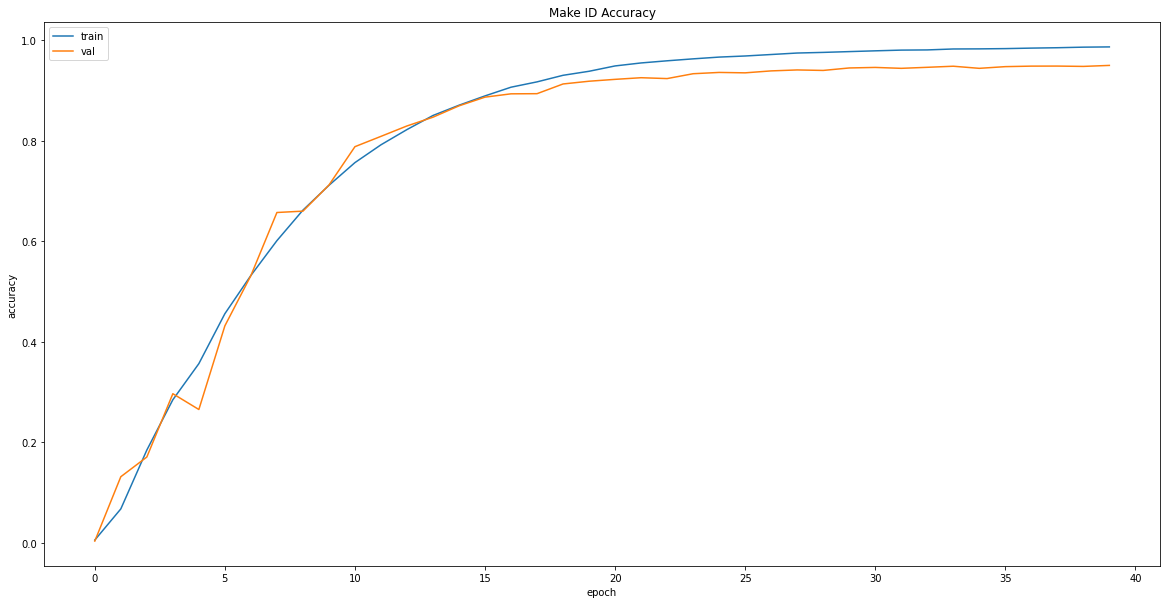

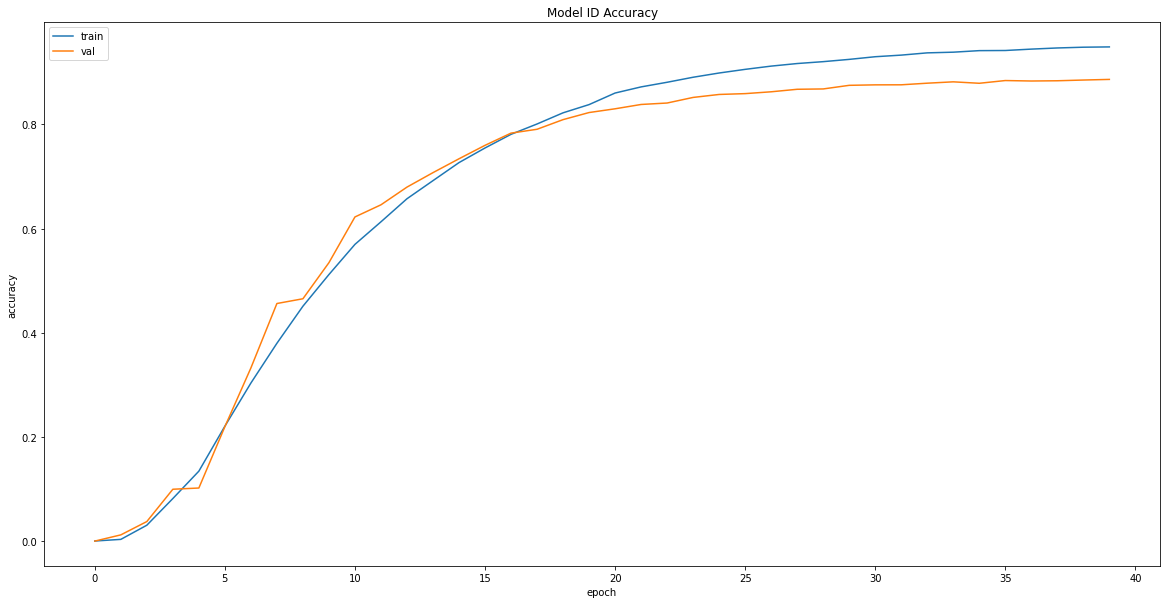

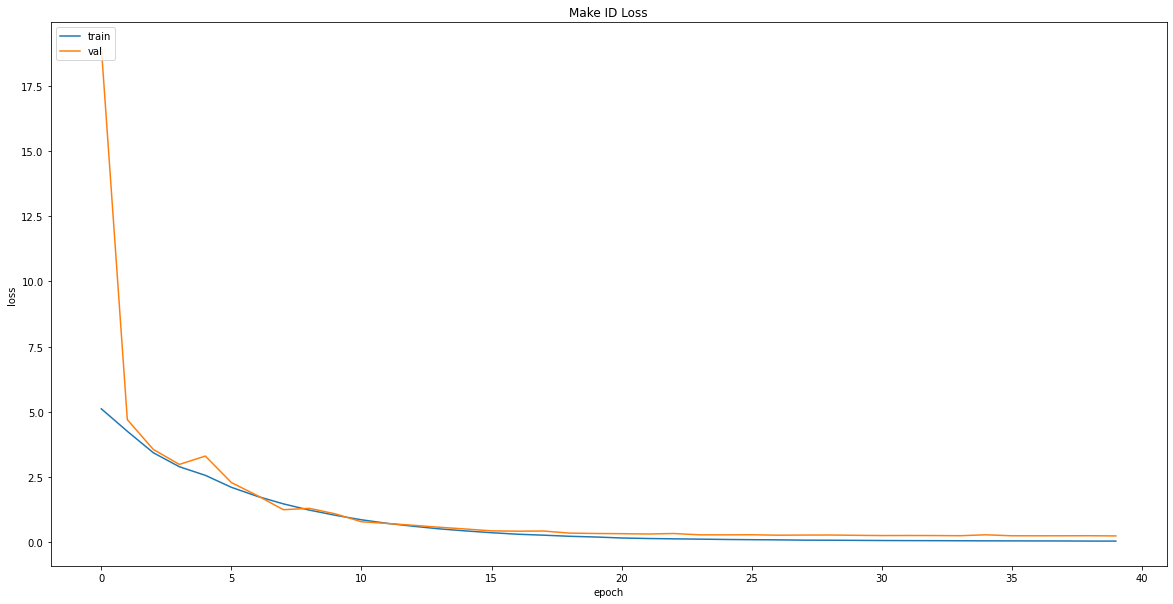

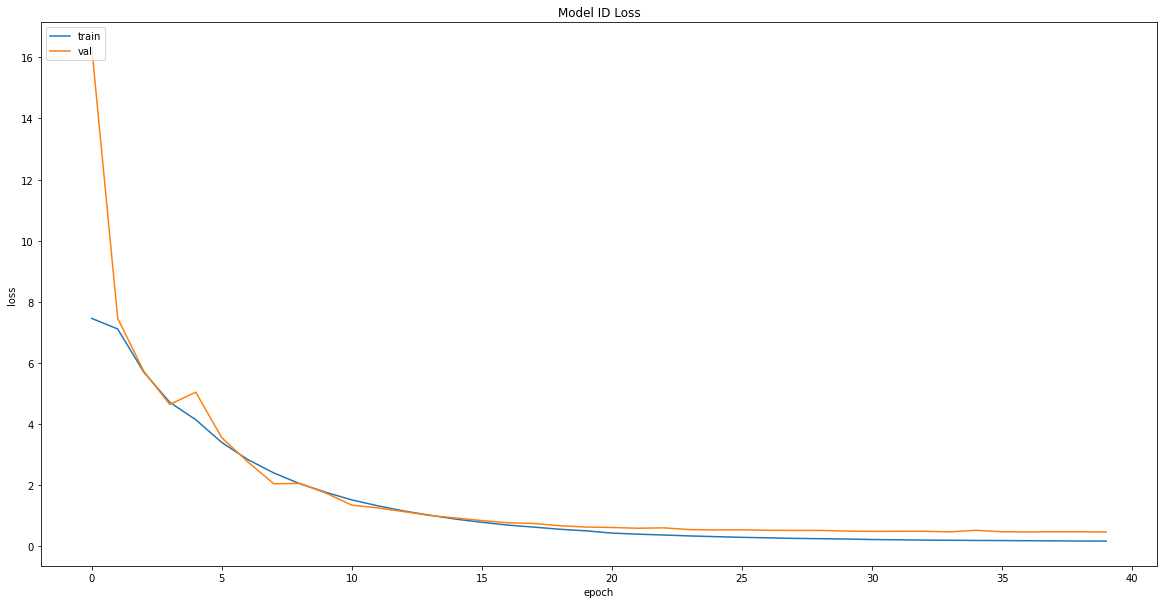

In [ ]:
# Display final result of all accuracy and loss graph
result(hist)

In [ ]:
# Evaluate with test dataset
model.evaluate(test_dataset)

215/215 [==============================] - 16s 75ms/step - loss: 1.2533 - make_id_loss: 0.3154 - model_id_loss: 0.7742 - make_id_accuracy: 0.9451 - model_id_accuracy: 0.8828


[1.2532660961151123,
 0.3154328465461731,
 0.7741979956626892,
 0.9451308250427246,
 0.882776141166687]